# Cell Admixture Tissue Feature Reduction Utilizing Support Vector Regression Recursive Feature Elimination

This notebook is meant to encompass the entire machine learning pipeline, from initial features to selected features.

1. [Import required packages and display version information](#imports-and-version-information) 
2. [Initial feature reduction](#initial-feature-reduction) 
    1. [Load data](#load-data)
        * Initial feature lists
        * CPTAC 
        * HGSOC 
        * Celladmixture tissue data
    2. [Split tissue data into test/train](#split-tissue-data-into-test-and-train-sets)
    3. [Hyperparameter tuning](#hyperparameter-tuning)
    4. [Perform RFE on reduced CPTAC + HGSOC + Protein Candidate features](#perform-rfe)
        * SVM SVR
        * Save model performances
    5. [Choose reduced featuresets](#choose-reduced-featuresets)
        * at least 15 features, lowest test MSE
3. [Validation](#validation)
    1. [CPTAC](#cptac)
        * model results
        * ssGSEA
    2. [N9 HGSOC](#hgsoc)
        * model results
        * ssGSEA

# Imports and Version Information<a id='imports-and-version-information'></a>

In [1]:
# Dataframes, Linear Algebra, Statistics
import pandas as pd
import numpy as np

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib as mpl
from seaborn.external.appdirs import system

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from matplotlib.legend_handler import HandlerTuple
from statannotations.Annotator import Annotator
import matplotlib as mpl

# Progress Bar
from tqdm import tqdm

# System
import os
import pickle
import subprocess
import json

# download data
import requests


# more graphing stuff
mpl.rcParams["savefig.dpi"] = 350 # dpi for saving figures
figure_path = 'figures' # folder for figures (will be created if it doesn't exist)
file_format = 'png' # figure file format
if figure_path not in os.listdir(): # if the figure folder filepath doesn't exist, make the folder
    print(f'Making `./{figure_path}`.')
    os.mkdir(figure_path)
else: # else, do nothing
    print(f'`./{figure_path}` already exists.')

font = {'weight' : 'normal',
    'size'   : 15}
mpl.rc('font', **font)

# data folder
data_folder = 'data'

`./figures` already exists.


In [2]:
print('Version information:')
! pip list | grep -E 'pandas|numpy|scipy|matplotlib|seaborn|scikit-learn'

Version information:
matplotlib                3.10.0
matplotlib-inline         0.1.6
numpy                     1.26.4
pandas                    2.0.3
scikit-learn              1.6.1
scipy                     1.15.2
seaborn                   0.13.2


# Initial Feature Reduction<a id='initial-feature-reduction'></a>
2. [Initial feature reduction](#initial-feature-reduction) 
    1. [Load data](#load-data)
        * Initial feature lists
        * CPTAC 
        * HGSOC 
        * Celladmixture tissue data
    2. [Split tissue data into test/train](#split-tissue-data-into-test-and-train-sets)
    3. [Hyperparameter tuning](#hyperparameter-tuning)
    4. [Perform RFE on reduced CPTAC + HGSOC + Protein Candidate features](#perform-rfe)
        * SVM SVR
        * Save model performances
    5. [Choose reduced featuresets](#choose-reduced-featuresets)
        * at least 15 features, lowest test MSE

## Load data<a id='load-data'></a>

### Protein Candidates


In [3]:
from pathlib import Path
DATASET = "MSV000086809"
DATA_FOLDER = Path(f'/Users/henning/PycharmProjects/CelltypeDeconvolution/data_bulk_processed/{DATASET}_ProteoMixture')


tls_strings = ['C10', 'RAW', 'SVEC']
tls_colors = {'C10':'#E41A1C', 'RAW':'#FFD700', 'SVEC':'#000080'}
protein_candidates = {}
file_path = Path(f'{DATA_FOLDER}/{DATASET}_ProteoMixture_protein_candidates.xlsx')
if not file_path.exists():
    print(file_path.absolute())
for cell_type in tls_strings:
    protein_candidates[cell_type] = pd.read_excel(file_path)


### Tissue Data

In [4]:
synthetic_bulk_protein_data = pd.read_csv(f'{DATA_FOLDER}/{DATASET}_ProteoMixture_bulk_protein_data.csv', index_col=0)
synthetic_bulk_protein_data.fillna(0, inplace=True)
print('Admixture Abundances dataframe shape:', synthetic_bulk_protein_data.shape)
synthetic_bulk_protein_data

Admixture Abundances dataframe shape: (2413, 100)


,0_C10:0.4_SVEC:0.2_RAW:0.4,10_C10:0.45_SVEC:0.15_RAW:0.4,11_C10:0.35_SVEC:0.4_RAW:0.25,12_C10:0.35_SVEC:0.3_RAW:0.35,13_C10:0.35_SVEC:0.25_RAW:0.4,14_C10:0.55_SVEC:0.2_RAW:0.25,15_C10:0.5_SVEC:0.25_RAW:0.25,16_C10:0.2_SVEC:0.3_RAW:0.5,17_C10:0.3_SVEC:0.3_RAW:0.4,18_C10:0.25_SVEC:0.3_RAW:0.45,...,91_C10:0.3_SVEC:0.35_RAW:0.35,92_C10:0.45_SVEC:0.2_RAW:0.35,93_C10:0.4_SVEC:0.3_RAW:0.3,94_C10:0.15_SVEC:0.45_RAW:0.4,95_C10:0.35_SVEC:0.25_RAW:0.4,96_C10:0.3_SVEC:0.5_RAW:0.2,97_C10:0.35_SVEC:0.4_RAW:0.25,98_C10:0.45_SVEC:0.35_RAW:0.2,99_C10:0.4_SVEC:0.4_RAW:0.2,9_C10:0.3_SVEC:0.4_RAW:0.3
Accession,,,,,,,,,,,,,,,,,,,,,
A1L314,7.303507,8.166725,8.377167,7.777913,7.303507,8.811712,6.625636,8.154590,8.596581,8.600229,...,8.413416,6.486956,7.507795,7.557961,8.777140,7.244602,7.542235,7.743259,7.683570,7.848986
A2A432,11.467996,11.290619,11.429285,11.466325,11.373730,11.926264,11.833976,10.896940,11.420023,11.604249,...,11.852740,11.788212,11.574590,11.271034,11.287482,11.586411,11.714164,11.970915,11.652645,11.810588
A2ADY9,8.769008,8.746627,8.889040,9.159455,9.255456,9.029514,8.594265,8.234161,8.894186,8.461561,...,9.228564,9.327827,8.745210,8.489306,7.927742,8.466258,8.411943,9.070585,8.674298,9.362615
A2AGT5,10.731363,10.911267,10.782963,9.816096,10.812491,10.556370,11.122864,10.336119,10.631412,10.289742,...,10.957035,10.954106,10.358489,10.667726,10.281528,10.836028,10.794083,10.860130,10.890813,11.076658
A2AN08,8.987585,8.981614,8.879396,8.794141,8.796510,8.757020,8.561928,8.901899,8.709592,8.639589,...,9.148127,8.925402,8.321482,8.290282,8.235744,8.841174,8.720701,8.631197,8.532821,8.114346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z2X1,13.509007,13.343505,13.189630,13.047794,13.244226,13.398257,13.587129,12.958344,12.969254,13.287376,...,13.213156,13.548809,13.064169,13.062656,12.979324,13.434238,13.335762,13.382272,13.452929,13.519760
Q9Z2X2,9.514633,9.016588,9.517438,9.160400,8.663693,9.475922,8.955088,9.144603,8.483681,9.136845,...,8.276722,9.576434,8.852700,8.714400,8.712143,9.089417,9.041357,7.398239,8.648667,9.241939
Q9Z2X8,4.788242,5.852526,6.207795,5.648465,4.788242,6.592008,4.550808,5.649486,6.109246,6.130138,...,6.353826,4.909701,5.731998,5.741386,6.703488,4.953684,5.307771,5.669004,5.428196,5.598824


In [5]:
admixture_tissue_annotation = synthetic_bulk_protein_data.copy().drop(columns=filter(lambda x: 'Accession' not in x, synthetic_bulk_protein_data.columns))
admixture_tissue_annotation['Gene'] = ""
admixture_tissue_annotation['Description'] = ""
admixture_tissue_annotation['seq.txt'] = ""
print('Admixture Annotation dataframe shape:', admixture_tissue_annotation.shape)
admixture_tissue_annotation

Admixture Annotation dataframe shape: (2413, 3)


,Gene,Description,seq.txt
Accession,,,
A1L314,,,
A2A432,,,
A2ADY9,,,
A2AGT5,,,
A2AN08,,,
...,...,...,...
Q9Z2X1,,,
Q9Z2X2,,,
Q9Z2X8,,,


### Get Final Dataset (overlaps)

In [6]:
# load the metadata
synthetic_bulk_metadata = pd.read_csv(f'{DATA_FOLDER}/{DATASET}_ProteoMixture_bulk_metadata.csv')
synthetic_bulk_metadata = synthetic_bulk_metadata.T
synthetic_bulk_metadata.columns = synthetic_bulk_metadata.iloc[0]
synthetic_bulk_metadata = synthetic_bulk_metadata[1:]
synthetic_bulk_metadata

Sample,0_C10:0.4_SVEC:0.4_RAW:0.2,1_C10:0.4_SVEC:0.4_RAW:0.2,2_C10:0.6_SVEC:0.1_RAW:0.3,3_C10:0.3_SVEC:0.3_RAW:0.4,4_C10:0.4_SVEC:0.2_RAW:0.4,5_C10:0.4_SVEC:0.3_RAW:0.3,6_C10:0.3_SVEC:0.2_RAW:0.5,7_C10:0.3_SVEC:0.4_RAW:0.3,8_C10:0.2_SVEC:0.4_RAW:0.4,9_C10:0.4_SVEC:0.1_RAW:0.5,...,90_C10:0.4_SVEC:0.3_RAW:0.3,91_C10:0.5_SVEC:0.1_RAW:0.4,92_C10:0.3_SVEC:0.2_RAW:0.5,93_C10:0.2_SVEC:0.3_RAW:0.5,94_C10:0.6_SVEC:0.2_RAW:0.2,95_C10:0.4_SVEC:0.4_RAW:0.2,96_C10:0.4_SVEC:0.3_RAW:0.3,97_C10:0.1_SVEC:0.5_RAW:0.4,98_C10:0.4_SVEC:0.4_RAW:0.2,99_C10:0.2_SVEC:0.4_RAW:0.4
C10,0.4,0.4,0.6,0.3,0.4,0.4,0.3,0.3,0.2,0.4,...,0.4,0.5,0.3,0.2,0.6,0.4,0.4,0.1,0.4,0.2
SVEC,0.4,0.4,0.1,0.3,0.2,0.3,0.2,0.4,0.4,0.1,...,0.3,0.1,0.2,0.3,0.2,0.4,0.3,0.5,0.4,0.4
RAW,0.2,0.2,0.3,0.4,0.4,0.3,0.5,0.3,0.4,0.5,...,0.3,0.4,0.5,0.5,0.2,0.2,0.3,0.4,0.2,0.4


In [7]:
print('Original abundances shape:', synthetic_bulk_protein_data)
# hgsoc overlap
# admixture_tissue_log2_imputed_abundances_hgsoc_overlap = admixture_tissue_log2_imputed_abundances[admixture_tissue_log2_imputed_abundances.index.isin(hgsoc_abundance.columns.values)]
# print('Overlap with n9 HGSOC shape:', admixture_tissue_log2_imputed_abundances_hgsoc_overlap.shape)
# cptac overlap
# final_admixture_tissue_log2_imputed_abundances = admixture_tissue_log2_imputed_abundances_hgsoc_overlap[admixture_tissue_log2_imputed_abundances_hgsoc_overlap.index.isin(cptac_accession_numbers.columns.values)]
# print('Overlap with n9 HGSOC and CPTAC (final) shape:', final_admixture_tissue_log2_imputed_abundances.shape)

# in concordance with the originally provided notebook
final_admixture_tissue_log2_imputed_abundances = synthetic_bulk_protein_data
final_admixture_tissue_log2_imputed_abundances


Original abundances shape:            0_C10:0.4_SVEC:0.2_RAW:0.4  10_C10:0.45_SVEC:0.15_RAW:0.4  \
Accession                                                              
A1L314                       7.303507                       8.166725   
A2A432                      11.467996                      11.290619   
A2ADY9                       8.769008                       8.746627   
A2AGT5                      10.731363                      10.911267   
A2AN08                       8.987585                       8.981614   
...                               ...                            ...   
Q9Z2X1                      13.509007                      13.343505   
Q9Z2X2                       9.514633                       9.016588   
Q9Z2X8                       4.788242                       5.852526   
Q9Z2Y8                       6.968840                       7.113185   
Q9Z315                       5.924563                       6.735549   

           11_C10:0.35_SVEC:0.4_RAW:

,0_C10:0.4_SVEC:0.2_RAW:0.4,10_C10:0.45_SVEC:0.15_RAW:0.4,11_C10:0.35_SVEC:0.4_RAW:0.25,12_C10:0.35_SVEC:0.3_RAW:0.35,13_C10:0.35_SVEC:0.25_RAW:0.4,14_C10:0.55_SVEC:0.2_RAW:0.25,15_C10:0.5_SVEC:0.25_RAW:0.25,16_C10:0.2_SVEC:0.3_RAW:0.5,17_C10:0.3_SVEC:0.3_RAW:0.4,18_C10:0.25_SVEC:0.3_RAW:0.45,...,91_C10:0.3_SVEC:0.35_RAW:0.35,92_C10:0.45_SVEC:0.2_RAW:0.35,93_C10:0.4_SVEC:0.3_RAW:0.3,94_C10:0.15_SVEC:0.45_RAW:0.4,95_C10:0.35_SVEC:0.25_RAW:0.4,96_C10:0.3_SVEC:0.5_RAW:0.2,97_C10:0.35_SVEC:0.4_RAW:0.25,98_C10:0.45_SVEC:0.35_RAW:0.2,99_C10:0.4_SVEC:0.4_RAW:0.2,9_C10:0.3_SVEC:0.4_RAW:0.3
Accession,,,,,,,,,,,,,,,,,,,,,
A1L314,7.303507,8.166725,8.377167,7.777913,7.303507,8.811712,6.625636,8.154590,8.596581,8.600229,...,8.413416,6.486956,7.507795,7.557961,8.777140,7.244602,7.542235,7.743259,7.683570,7.848986
A2A432,11.467996,11.290619,11.429285,11.466325,11.373730,11.926264,11.833976,10.896940,11.420023,11.604249,...,11.852740,11.788212,11.574590,11.271034,11.287482,11.586411,11.714164,11.970915,11.652645,11.810588
A2ADY9,8.769008,8.746627,8.889040,9.159455,9.255456,9.029514,8.594265,8.234161,8.894186,8.461561,...,9.228564,9.327827,8.745210,8.489306,7.927742,8.466258,8.411943,9.070585,8.674298,9.362615
A2AGT5,10.731363,10.911267,10.782963,9.816096,10.812491,10.556370,11.122864,10.336119,10.631412,10.289742,...,10.957035,10.954106,10.358489,10.667726,10.281528,10.836028,10.794083,10.860130,10.890813,11.076658
A2AN08,8.987585,8.981614,8.879396,8.794141,8.796510,8.757020,8.561928,8.901899,8.709592,8.639589,...,9.148127,8.925402,8.321482,8.290282,8.235744,8.841174,8.720701,8.631197,8.532821,8.114346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z2X1,13.509007,13.343505,13.189630,13.047794,13.244226,13.398257,13.587129,12.958344,12.969254,13.287376,...,13.213156,13.548809,13.064169,13.062656,12.979324,13.434238,13.335762,13.382272,13.452929,13.519760
Q9Z2X2,9.514633,9.016588,9.517438,9.160400,8.663693,9.475922,8.955088,9.144603,8.483681,9.136845,...,8.276722,9.576434,8.852700,8.714400,8.712143,9.089417,9.041357,7.398239,8.648667,9.241939
Q9Z2X8,4.788242,5.852526,6.207795,5.648465,4.788242,6.592008,4.550808,5.649486,6.109246,6.130138,...,6.353826,4.909701,5.731998,5.741386,6.703488,4.953684,5.307771,5.669004,5.428196,5.598824


## Split Tissue Data Into Test and Train Sets<a id='split-tissue-data-into-test-and-train-sets'></a>

There are 16 samples, so 10 will be used for training, and 6 for testing. Additionally, test/train sets will be decided for each tissue subtype, and will be stratified to a feature generated by the amount of that type of tissue (giving test and train sets similar distribution of tissue %).

### Get features from sample names

In [8]:
# in concordance with the originally provided notebook
target = synthetic_bulk_metadata
target

Sample,0_C10:0.4_SVEC:0.4_RAW:0.2,1_C10:0.4_SVEC:0.4_RAW:0.2,2_C10:0.6_SVEC:0.1_RAW:0.3,3_C10:0.3_SVEC:0.3_RAW:0.4,4_C10:0.4_SVEC:0.2_RAW:0.4,5_C10:0.4_SVEC:0.3_RAW:0.3,6_C10:0.3_SVEC:0.2_RAW:0.5,7_C10:0.3_SVEC:0.4_RAW:0.3,8_C10:0.2_SVEC:0.4_RAW:0.4,9_C10:0.4_SVEC:0.1_RAW:0.5,...,90_C10:0.4_SVEC:0.3_RAW:0.3,91_C10:0.5_SVEC:0.1_RAW:0.4,92_C10:0.3_SVEC:0.2_RAW:0.5,93_C10:0.2_SVEC:0.3_RAW:0.5,94_C10:0.6_SVEC:0.2_RAW:0.2,95_C10:0.4_SVEC:0.4_RAW:0.2,96_C10:0.4_SVEC:0.3_RAW:0.3,97_C10:0.1_SVEC:0.5_RAW:0.4,98_C10:0.4_SVEC:0.4_RAW:0.2,99_C10:0.2_SVEC:0.4_RAW:0.4
C10,0.4,0.4,0.6,0.3,0.4,0.4,0.3,0.3,0.2,0.4,...,0.4,0.5,0.3,0.2,0.6,0.4,0.4,0.1,0.4,0.2
SVEC,0.4,0.4,0.1,0.3,0.2,0.3,0.2,0.4,0.4,0.1,...,0.3,0.1,0.2,0.3,0.2,0.4,0.3,0.5,0.4,0.4
RAW,0.2,0.2,0.3,0.4,0.4,0.3,0.5,0.3,0.4,0.5,...,0.3,0.4,0.5,0.5,0.2,0.2,0.3,0.4,0.2,0.4


### Create features to stratify to
Creating 3 groups for each feature to try and evenly spread % values between test and train sets.

In [9]:
# create a feature that is 0, 1, or 2 depending on whether the cell type percentage is 0-24%, 25-75%, and 75-100%
target_stratify = pd.DataFrame(columns=synthetic_bulk_metadata.columns)
target_stratify = target_stratify.T

for tissue_type in synthetic_bulk_metadata.index:
    temp = []
    for tissue_percentage, sample in zip(target.T[tissue_type], target.columns):
        if tissue_percentage < 0.15:
            temp.append(0)
        elif tissue_percentage >= 0.15 and tissue_percentage < 0.35:
            temp.append(1)
        else:
            temp.append(2)
    target_stratify[tissue_type] = temp
target_stratify

,C10,SVEC,RAW
Sample,,,
0_C10:0.4_SVEC:0.4_RAW:0.2,2,2,1
1_C10:0.4_SVEC:0.4_RAW:0.2,2,2,1
2_C10:0.6_SVEC:0.1_RAW:0.3,2,0,1
3_C10:0.3_SVEC:0.3_RAW:0.4,1,1,2
4_C10:0.4_SVEC:0.2_RAW:0.4,2,1,2
...,...,...,...
95_C10:0.4_SVEC:0.4_RAW:0.2,2,2,1
96_C10:0.4_SVEC:0.3_RAW:0.3,2,1,1
97_C10:0.1_SVEC:0.5_RAW:0.4,0,2,2


### Create test/train splits for each target
Essentially three separate models will be made. They will eventually be combined to create a predictor.

In [10]:
# create directories to hold test/train data
for tissue_type in tls_strings:
    try:
        os.mkdir(f'{data_folder}/{tissue_type}')
        print(f'Created folder at `{data_folder}/{tissue_type}`')
    except FileExistsError:
        print(f'`{data_folder}/{tissue_type}` already exists.')

`data/C10` already exists.
`data/RAW` already exists.
`data/SVEC` already exists.


In [11]:
final_admixture_tissue_log2_imputed_abundances = synthetic_bulk_protein_data
print('CPTAC/HGSOC abundance overlap shape:', final_admixture_tissue_log2_imputed_abundances.shape)
for tissue_type in tls_strings:
    print(f'Making train/test for {tissue_type}...')

    # overlap with protein candidates!!!
    final_protein_candidate_data = final_admixture_tissue_log2_imputed_abundances[final_admixture_tissue_log2_imputed_abundances.index.isin(protein_candidates[tissue_type]['UniProt Accession'])]
    print(f'Final CPTAC/HGSOC/{tissue_type} protein candidate abundance overlap shape:', final_protein_candidate_data.shape)

    # get train/test split
    X_train, X_test, y_train, y_test = train_test_split(final_protein_candidate_data.T, target.T[[tissue_type]], test_size=0.33, random_state=42, stratify=target_stratify[[tissue_type]])
    
    # print sizes
    print('X_train shape:', X_train.shape)
    print('X_test shape :', X_test.shape)

    # save them in their respective folders
    print(f'Saving train and test splits in `{data_folder}/{tissue_type}/`')
    datasets = [('X_train', X_train), ('X_test', X_test), ('y_train', y_train), ('y_test', y_test)] 
    for name, data in datasets:
        data.to_csv(f'{data_folder}/{tissue_type}/Tissue_{name}_{tissue_type}.csv')

CPTAC/HGSOC abundance overlap shape: (2413, 100)
Making train/test for C10...
Final CPTAC/HGSOC/C10 protein candidate abundance overlap shape: (776, 100)
X_train shape: (67, 776)
X_test shape : (33, 776)
Saving train and test splits in `data/C10/`
Making train/test for RAW...
Final CPTAC/HGSOC/RAW protein candidate abundance overlap shape: (776, 100)
X_train shape: (67, 776)
X_test shape : (33, 776)
Saving train and test splits in `data/RAW/`
Making train/test for SVEC...
Final CPTAC/HGSOC/SVEC protein candidate abundance overlap shape: (776, 100)
X_train shape: (67, 776)
X_test shape : (33, 776)
Saving train and test splits in `data/SVEC/`


In [12]:
# load saved data
data_sections = ['X_train', 'X_test', 'y_train', 'y_test']

data = {}

# read in data in loops 
for tissue_type in tls_strings:
    temp_tissue = {}
    for ml_section in data_sections:
        f = pd.read_csv(f'{data_folder}/{tissue_type}/Tissue_{ml_section}_{tissue_type}.csv', index_col=0)
        temp_tissue[ml_section] = f
    data[tissue_type] = temp_tissue
print('Outer-most keys:')
print(data.keys())
print('Inner keys:')
print(data[tls_strings[0]].keys())

Outer-most keys:
dict_keys(['C10', 'RAW', 'SVEC'])
Inner keys:
dict_keys(['X_train', 'X_test', 'y_train', 'y_test'])


In [13]:
# save data
pickle.dump(data, open(f"{data_folder}/admixture/data.pkl", 'wb'))

## Hyperparameter tuning<a id='hyperparameter-tuning'></a>

Here, I create a parameter grid, and using sklearn's GridSearchCV function, each set of parameters is used to train and test a model 5 times. The parameters that get the best average score end up being the parameters that are used to create the models that will be recursively trained in RFE.

In [14]:
# create parameter grid
svr_parameter_grid = [
    {'kernel': ['linear'], 
    'C': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
    'epsilon': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
]
# the larger epsilon, the more error is allowed within model
# C is multiplied to the regularization 

folds = 5 # 5 fold, each test set will have 2 samples
print('Using a grid search approach to tune hyperparameters for Support Vector Regression')

svr = svm.SVR()
grid_search = GridSearchCV(svr, svr_parameter_grid, n_jobs=-1, cv=folds)

# create dictionary to hold hyperparameters for each tissue type
hyperparameters = {}

for tissue_type in tqdm(tls_strings):
    X_train, y_train = data[tissue_type]['X_train'], np.ravel(data[tissue_type]['y_train'])
    grid_search.fit(X_train, y_train)
    hyperparameters[tissue_type] = grid_search.best_params_

Using a grid search approach to tune hyperparameters for Support Vector Regression


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


In [15]:
print(f'Hyperparameters found by grid search using a {folds} fold Cross-Validation')
hyperparameters

Hyperparameters found by grid search using a 5 fold Cross-Validation


{'C10': {'C': 0.01, 'epsilon': 0.1, 'kernel': 'linear'},
 'RAW': {'C': 0.001, 'epsilon': 0.01, 'kernel': 'linear'},
 'SVEC': {'C': 0.0001, 'epsilon': 0.2, 'kernel': 'linear'}}

In [16]:
# defaults
"""
for tissue_type in tls_strings:
    for argument, value in [('C', 1), ('epsilon', 0.1), ('kernel', 'linear')]:
        hyperparameters[tissue_type][argument] = value
"""
print('Printing hyperparameters that will be used:')
hyperparameters

Printing hyperparameters that will be used:


{'C10': {'C': 0.01, 'epsilon': 0.1, 'kernel': 'linear'},
 'RAW': {'C': 0.001, 'epsilon': 0.01, 'kernel': 'linear'},
 'SVEC': {'C': 0.0001, 'epsilon': 0.2, 'kernel': 'linear'}}

## Perform RFE<a id='perform-rfe'></a>

Recursive Feature Elimination, or RFE, is used here to choose a subset of genes that hold the most predictive power for an support vector regressor (SVR). This can help reduce reduncancies when utilizing tools such as ssGSEA for gene set enrichment analyses.

RFE is performed 3 times, once for each tissue type (stroma, lymphocyte, or tumor). The ranks provided by RFE are then used to re-train models and assess their performance on test data. This is visualized with a scatterplot of the mean squared error (MSE) on the y-axis, and number of features on the x-axis. 

In [17]:
rankings = {}
model_performances = {}
best_models = {}

Performing RFE per Target (['C10', 'RAW', 'SVEC'])
---- C10 RFE ----
Train models with each set of features, removing least important ones (by RFE rank):


100%|██████████| 776/776 [00:02<00:00, 338.66it/s]


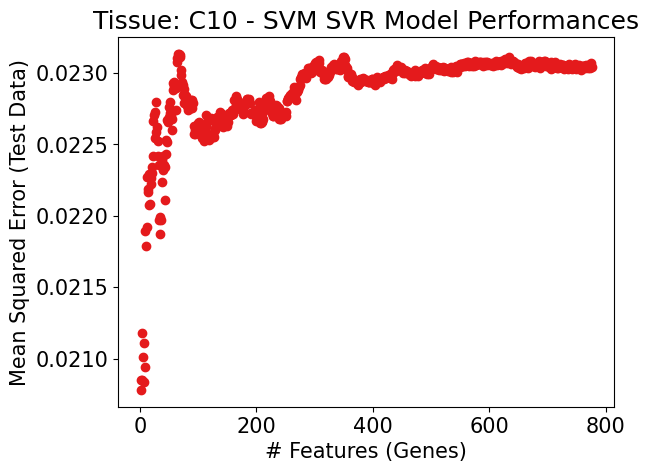

---- RAW RFE ----
Train models with each set of features, removing least important ones (by RFE rank):


100%|██████████| 776/776 [00:02<00:00, 342.97it/s]


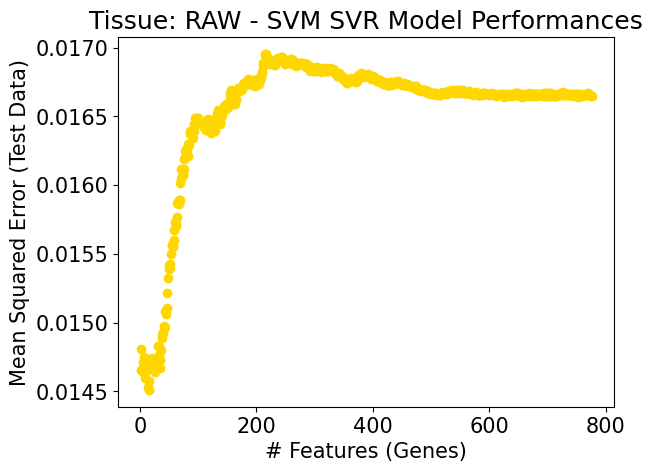

---- SVEC RFE ----
Train models with each set of features, removing least important ones (by RFE rank):


100%|██████████| 776/776 [00:01<00:00, 388.70it/s]


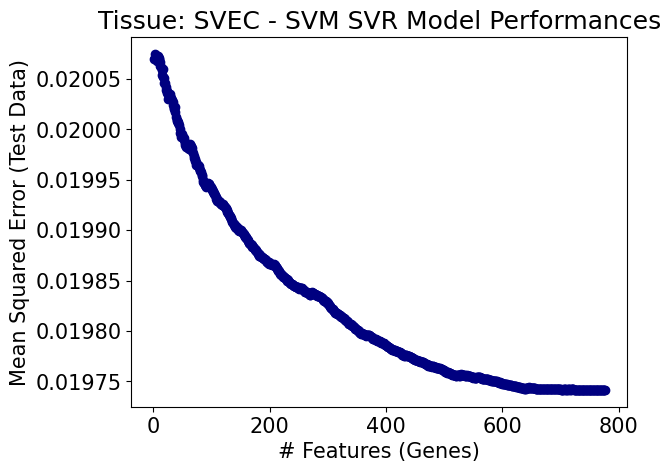

In [18]:
print(f'Performing RFE per Target ({tls_strings})')
for tissue_type in tls_strings:
    print('----', tissue_type, 'RFE ----')
    # define estimator based on hyperparameter tuning
    svr = svm.SVR(**hyperparameters[tissue_type])
    
    # define an RFE
    rfe = RFE(estimator=svr, n_features_to_select=1, step=1, verbose=False)

    # get train data
    X_train, y_train = data[tissue_type]['X_train'], np.ravel(data[tissue_type]['y_train'])

    # fit rfe to get ranking
    rfe.fit(X_train, y_train)
    ranking = rfe.ranking_
    rankings[tissue_type] = ranking

    # get test data
    y_test, X_test = data[tissue_type]['y_test'], data[tissue_type]['X_test']

    # fit all models at different featurelist sizes and plot accuracies
    mse_dict = {}
    models = {}
    min_mse = np.inf
    best_model = None
    print('Train models with each set of features, removing least important ones (by RFE rank):')
    for num_features in tqdm(range(X_train.shape[1], 0, -1)): # for each protein
        rank = pd.Series(ranking, index=X_train.columns).sort_values() # sort by importance rank
        
        # take the top i ranks of training data
        top_num_features = rank.iloc[:num_features]
        top_num_features = X_train[top_num_features.index]

        # fit svr to reduced featurelist training data
        svr.fit(top_num_features, np.ravel(y_train))
        
        # get predictions for reduced features
        y_pred = svr.predict(X_test[top_num_features.columns])
        
        # calculate mean squared error between predictions and actual
        mse = mean_squared_error(y_test, y_pred)

        # get the bets model
        if mse < min_mse:
            min_mse = mse
            best_model = (top_num_features.shape, top_num_features)

        # add to mse dictionary
        mse_dict[num_features] = mse

        # add model to model dictionary
        models[num_features] = (mse, top_num_features)
    pickle.dump(models, open(f'{data_folder}/{tissue_type}/{tissue_type}_model_performances.pkl', 'wb'))

    model_performances[tissue_type] = models

    fig, ax = plt.subplots()
    ax.set_xlabel('# Features (Genes)')
    ax.set_ylabel('Mean Squared Error (Test Data)')
    ax.set_title(f'Tissue: {tissue_type} - SVM SVR Model Performances')
    best_models[tissue_type] = best_model
    plt.scatter(x=mse_dict.keys(), y=mse_dict.values(), color=tls_colors[tissue_type])

    plt.savefig(f'{figure_path}/tissue_{tissue_type}_svm_svr_model_performances.{file_format}', format=file_format)

    plt.show()

In [19]:
# save rankings
pickle.dump(rankings, open(f'{data_folder}/admixture/rankings.pkl', 'wb'))

## Decide on Model for Reduced Featuresets<a id='choose-reduced-featuresets'></a>

To choose a subset of genes for each tissue type, the model with the lowest test MSE with at least 15 features is chosen. The features used in these models will be the reduced featurelists for tools such as ssGSEA. 

Aside: It might be worth looking into choosing models around the 'elbow' of the previous scatterplots. This is where the models don't necessarily have the lowest MSE, but have the fewest features/genes, and could further reduce redundancy while maintaining predictive power.

### Lowest MSE with at least 15 features
This ends up being just the lowest MSE models

In [20]:
min_num_features = 15

In [21]:
tls_features = {}
prediction_dataframe_parts = {}
for tissue_type in tls_strings:
    tissue_specific_model_performances = pd.DataFrame([(x, model_performances[tissue_type][x][0], model_performances[tissue_type][x][1]) for x in model_performances[tissue_type].keys()]).rename(columns={0:'num_features', 1:'mse', 2:'dfs'})
    # sort by MSE
    sorted_model_performances = tissue_specific_model_performances.sort_values(ascending = True, by='mse')
    # remove lower than 15 features, and get the number of features with the lowest MSE
    n_features = sorted_model_performances[sorted_model_performances.num_features >= min_num_features].iloc[0,:].num_features
    this_mse = sorted_model_performances[sorted_model_performances.num_features == n_features].mse.values[0]
    lowest_mse = np.min(tissue_specific_model_performances['mse'])
    print(f'---- {tissue_type} results ----')
    print(f'lowest test MSE of ALL models ---------------------- = {lowest_mse}')
    print(f'lowest test MSE with greater or equal to {min_num_features} features = {this_mse}')
    print(f'all features = {sorted_model_performances.shape[0]}')
    print(f'n features - = {n_features}')
    

    # get the model !
    # define estimator based on hyperparameter tuning
    svr = svm.SVR(**hyperparameters[tissue_type])

    # get train data
    y_train = np.ravel(data[tissue_type]['y_train'])
    X_train = model_performances[tissue_type][n_features][1]
    

    X_train.columns = X_train.columns.astype(str)

    # get test data
    X_test, y_test = data[tissue_type]['X_test'], np.ravel(data[tissue_type]['y_test'])

    # fit svr
    svr.fit(X_train, y_train)

    # predict svr
    y_pred = svr.predict(X_test[X_train.columns])
    prediction_dataframe_parts[tissue_type] = pd.DataFrame(y_pred, index=X_test.index, columns=[tissue_type])
    #print(f'Predictions shape: {prediction_dataframe_parts[tissue_type].shape}')
    #print(f'Predictions index: {prediction_dataframe_parts[tissue_type].index}')

    assert this_mse == mean_squared_error(y_test, y_pred), 'LOWEST MSES DO NOT MATCH' # check for reproducibility

    model_location = f'{data_folder}/{tissue_type}/{tissue_type}_svr_sklearn_at_least_{min_num_features}_model_cptac_candidate_{DATASET}.pkl'
    print(f'Writing pickled object file to `{model_location}`')
    pickle.dump(svr, open(model_location, 'wb'))

    # get features
    tls_features[tissue_type] = list(X_train.columns)

# combine predictions
predictions = pd.concat(prediction_dataframe_parts.values(), axis=1)
# sort by index
predictions = predictions.sort_index(axis=0).T.reset_index()
predictions.rename(columns={'index':'Cell Type'}, inplace=True)
print(predictions.shape)
print(predictions.columns)
print(predictions.head(10))
predictions.to_csv(f'../../deconvolution_results/{DATASET}_ProteoMixture.csv', index=False)


---- C10 results ----
lowest test MSE of ALL models ---------------------- = 0.020780075010986554
lowest test MSE with greater or equal to 15 features = 0.021874386354441437
all features = 776
n features - = 35
Writing pickled object file to `data/C10/C10_svr_sklearn_at_least_15_model_cptac_candidate_MSV000086809.pkl`
---- RAW results ----
lowest test MSE of ALL models ---------------------- = 0.014511296825276798
lowest test MSE with greater or equal to 15 features = 0.014511296825276798
all features = 776
n features - = 15
Writing pickled object file to `data/RAW/RAW_svr_sklearn_at_least_15_model_cptac_candidate_MSV000086809.pkl`
---- SVEC results ----
lowest test MSE of ALL models ---------------------- = 0.01974156247472196
lowest test MSE with greater or equal to 15 features = 0.01974156247472196
all features = 776
n features - = 744
Writing pickled object file to `data/SVEC/SVEC_svr_sklearn_at_least_15_model_cptac_candidate_MSV000086809.pkl`
(3, 71)
Index(['Cell Type', '10_C10:0.

In [22]:
# save json file with features for each model
# serializing
json_object = json.dumps(tls_features, indent=4)

# write file
with open(f'{data_folder}/admixture/tls_gene_sets.json', 'w') as f:
    f.write(json_object)

# Validation<a id='validation'></a>
3. [Validation](#validation)
    1. [CPTAC](#cptac)
        * model results
        * ssGSEA
    2. [N9 HGSOC](#hgsoc)
        * model results
        * ssGSEA

In [23]:
model_type = f'At Least {min_num_features} Features, Lowest MSE'

In [37]:
chosen_models = {}
for tissue_type in tls_strings:
    model_location = f'{data_folder}/{tissue_type}/{tissue_type}_svr_sklearn_at_least_{min_num_features}_model_cptac_candidate_{DATASET}.pkl'
    chosen_models[tissue_type] = pickle.load(open(model_location, 'rb'))

### Estimator function
Defined here is the function that takes 3 provided models and outputs a value for each.

Negative model outputs are clipped to 0 (negative values are set to 0), and then the model outputs are each divided by their sum (they all add to 1). This is done so that the model outputs mimic % sample values.

In [38]:
# create a function that takes X as input, and outputs normalized values from estimators
def run_estimators(X: pd.DataFrame, models: dict):
    """
    A function that takes normalized abundance values and outputs normalized tissue scores for each cell type.

    Parameters:
    X: pd.DataFrame - Input data with features.
    models: dict - Dictionary where keys are cell types and values are the corresponding trained models.

    Returns:
    pd.DataFrame - Predictions for each cell type, normalized to sum to 1.
    """
    
    # ensure that X has all the required accession numbers
    accession_numbers = np.unique([feature for model in models.values() for feature in model.feature_names_in_])

    # predictions
    predictions = {}

    # make predictions
    for tissue_type, model in models.items():
        tX = X.T[X.columns.isin(model.feature_names_in_)].T
        # make missing features 0
        missing_features = list(set(model.feature_names_in_) - set(X.columns))
        if missing_features:
            print(f'{tissue_type} has missing features (all values set to 0): {missing_features}')
            print(f'{len(missing_features)/len(model.feature_names_in_) * 100:.2f}% missing for {tissue_type} model...')
            for missing_feature in missing_features:
                tX[missing_feature] = 0
        
        # predict
        tX = tX[model.feature_names_in_]
        tX.columns = tX.columns.astype(str)

        assert (tX.columns == model.feature_names_in_).all() 

        predictions[tissue_type] = model.predict(X=tX)

    # clip values lower than 0 and higher than 1
    predictions_df = np.clip(pd.DataFrame(predictions, index=X.index), 0, 1)

    # make sure values add to 1
    predictions_df = (predictions_df.T / predictions_df.sum(axis=1)).T

    return predictions_df


In [39]:
predictions_df = run_estimators(X=final_admixture_tissue_log2_imputed_abundances.T, models=chosen_models)
print('Final predictions shape:', predictions_df.shape)
predictions_df.head(100)
predictions = predictions_df.T
predictions = predictions.reset_index()
predictions.rename(columns={'index':'Cell Type'}, inplace=True)
predictions.to_csv(f'../../deconvolution_results/{DATASET}_ProteoMixture.csv', index=False)

Final predictions shape: (100, 3)


## CPTAC<a id='cptac'></a>

Here, I apply both the SVR models created, and ssGSEA methods to a Clinical Proteomic Tumor Analysis Consortium dataset, containing proteomic data from ovarian cancer samples. This serves as an external dataset for validation, with molecular subtypes based on transcriptomics being a surrogate for tissue type. 

In [27]:
validation_name = 'CPTAC'

### Model Outputs

In [28]:
for tissue_type in chosen_models:
    print(f' --- {tissue_type} --- ')
    print(f'Number of features: {len(chosen_models[tissue_type].feature_names_in_)}')

 --- C10 --- 
Number of features: 611
 --- RAW --- 
Number of features: 212
 --- SVEC --- 
Number of features: 210


In [29]:
model_outputs = run_estimators(X=cptac_accession_numbers, stroma_model=chosen_models['Stroma'], tumor_model=chosen_models['Tumor'], lymphocyte_model=chosen_models['Lymphocyte'])
model_outputs = model_outputs.merge(cptac_molecular_subtypes, left_index=True, right_index=True)
model_outputs

NameError: name 'cptac_accession_numbers' is not defined

In [ ]:
scaffold = pd.DataFrame(columns=model_outputs.columns).drop(columns=['Stroma', 'Tumor']).rename(columns={'Lymphocyte':'Estimator Value'})
scaffold['Estimator'] = []
for x in tls_strings:
    temp = model_outputs[[x, 'prediction', 'ID', 'ProteomicSubtype']].rename(columns={x:'Estimator Value'})
    temp['Estimator'] = x
    scaffold = pd.concat([scaffold, temp])
scaffold = scaffold.reset_index()

plt.figure(figsize=(15, 8))
hue_order = tls_strings
ax = sns.boxplot(data=scaffold, x='ProteomicSubtype', y='Estimator Value', hue='Estimator', boxprops={'alpha':0.6}, hue_order=hue_order, palette=tls_colors)
sns.swarmplot(data=scaffold, x='ProteomicSubtype', y='Estimator Value', hue='Estimator', dodge=True, hue_order=hue_order, palette=tls_colors, linewidth=0.1, alpha=0.8)
ax.set_title(f'{model_type}: {validation_name} Validation')
ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[3]), (handles[1], handles[4]), (handles[2], handles[5])],
          labels=hue_order,
          loc='upper right', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})
          
pairs = [
    (('Mesenchymal', 'Stroma'), ('Mesenchymal', 'Tumor')),
    (('Mesenchymal', 'Stroma'), ('Mesenchymal', 'Lymphocyte')),
    (('Immunoreactive', 'Lymphocyte'), ('Immunoreactive', 'Tumor')),
    (('Immunoreactive', 'Lymphocyte'), ('Immunoreactive', 'Stroma')),
    (('Differentiated', 'Tumor'), ('Differentiated', 'Lymphocyte')),
    (('Differentiated', 'Tumor'), ('Differentiated', 'Stroma')),
    (('Proliferative', 'Tumor'), ('Proliferative', 'Lymphocyte')),
    (('Proliferative', 'Tumor'), ('Proliferative', 'Stroma')),
    (('Stromal', 'Stroma'), ('Stromal', 'Lymphocyte')),
    (('Stromal', 'Stroma'), ('Stromal', 'Tumor'))
]
annot = Annotator(ax, pairs, data=scaffold, x='ProteomicSubtype', y='Estimator Value', hue='Estimator', hue_order=hue_order)
annot.configure(test='Mann-Whitney', verbose=2, text_format='star')
annot.apply_test()
annot.annotate()

plt.savefig(f'{figure_path}/{validation_name}_validation_{model_type.replace(" ", "-").replace(",", "")}_tissue_boxplots.{file_format}', format=file_format)

plt.show()

In [ ]:
scaffold = pd.DataFrame(columns=tls_strings).T

for subtype in model_outputs.ProteomicSubtype.unique():
    temp = model_outputs[model_outputs.ProteomicSubtype == subtype]
    v_counts = temp.prediction.value_counts()
    temp_scores = {}
    for score in tls_strings:
        try:
            temp_scores[score] = v_counts[score]/v_counts.sum()
        except:
            print(f'{score} - not in {subtype} v_counts... Putting count of 0')
            temp_scores[score] = 0
    temp_scores = pd.Series(temp_scores)
    scaffold[subtype] = temp_scores
scaffold = scaffold.T
scaffold.reset_index().rename(columns={'index':'ProteomicSubtype'})
ax = scaffold.plot(kind='bar', stacked=True, figsize=(15, 8), color=tls_colors.values())
ax.set_title(f'{model_type}: CPTAC Validation')
ax.set_xlabel('ProteomicSubtype')
ax.set_ylabel('% Classified')
ax.spines[['right', 'top']].set_visible(False)

plt.xticks(rotation = 0)

plt.savefig(f'{figure_path}/{validation_name}_validation_{model_type.replace(" ", "-").replace(",", "")}_tissue_stacked_bar.{file_format}', format=file_format)

plt.show()

### ssGSEA

In [ ]:
file_names = {}
for tissue_type in tls_strings:
    model_location = f'{data_folder}/{tissue_type}/{tissue_type}_svr_sklearn_at_least_{min_num_features}_model_cptac_candidate_HGSOC.pkl'
    model = pickle.load(open(model_location, 'rb'))
    print(tissue_type, 'Model N features (genes):', len(model.feature_names_in_))

    file_name = f'{data_folder}/{tissue_type}/model_features_{tissue_type}.csv'
    pd.Series(model.feature_names_in_).to_csv(file_name)

    file_names[tissue_type] = file_name

In [ ]:
# expression file (Admixture)
expression_file = f'{data_folder}/CPTAC/020323_CPTAC_Ovarian_n174_Imputed8242Proteins_ACCESSION_NUMBERS.csv'
output_file_name = 'ssGSEA_cptac'

output_directory = f'{data_folder}/ssGSEA'
try:
    os.mkdir(output_directory)
except FileExistsError:
    print(output_directory, 'already exists...')


# run GSEA R script
process = subprocess.run(['Rscript', 'GSEA.r', expression_file, output_directory, output_file_name, file_names['Lymphocyte'], file_names['Stroma'], file_names['Tumor']])
process.check_returncode() # errors if there is a non-zero exit status

In [ ]:
subtype = pd.read_csv(f'{data_folder}/CPTAC/020323_CPTAC_Ovarian_n169_MolecularSubtypes.txt', sep='\t', index_col=1).drop(columns=['ID'])
#subtype.index = subtype.index.str.replace('-', '.')

# get colors for types
subtype_colors_dict = dict(zip(subtype.ProteomicSubtype.unique(), sns.color_palette('hls', len(subtype.ProteomicSubtype.unique()))))
subtype_colors = subtype.ProteomicSubtype.map(subtype_colors_dict)

In [ ]:
ssGSEA = pd.read_csv(f'{data_folder}/ssGSEA/{output_file_name}.csv', index_col=0)

ssGSEAt = ssGSEA.T
ssGSEAt['prediction'] = ssGSEAt.idxmax(axis=1)
ssGSEAt['ProteomicSubtype'] = subtype.ProteomicSubtype

absolute_max_ssGSEA = max(abs(ssGSEA.min().min()), abs(ssGSEA.max().max()))

# change dpi ..?
# plt.rcParams['figure.dpi'] = 200
g = sns.clustermap(data = ssGSEA, cmap='vlag', linewidth=.5, col_colors=subtype_colors, figsize=(18, 8), vmin=-absolute_max_ssGSEA, vmax=absolute_max_ssGSEA)
# custom legend
legend_elements = [Line2D([0], [0], lw=7, color=subtype_colors_dict[x], label=x) for x in subtype_colors_dict]
plt.legend(handles=legend_elements, loc=(1.6, 0.2))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

plt.savefig(f'{figure_path}/{validation_name}_ssGSEA_{model_type.replace(" ", "-").replace(",", "")}_tissue_dendro_heatmap.{file_format}', format=file_format)

plt.show()

In [ ]:
ssGSEAt = ssGSEA.T
ssGSEAt['prediction'] = ssGSEAt.idxmax(axis=1)
ssGSEAt['ProteomicSubtype'] = cptac_molecular_subtypes['ProteomicSubtype']

scaffold = pd.DataFrame(columns=ssGSEAt.columns).drop(columns=['Stroma', 'Tumor']).rename(columns={'Lymphocyte':'ssGSEA'})
scaffold['Estimator'] = []
for x in tls_strings:
    temp = ssGSEAt[[x, 'ProteomicSubtype', 'prediction']].rename(columns={x:'ssGSEA'})
    temp['Estimator'] = x
    scaffold = pd.concat([scaffold, temp])
scaffold = scaffold.reset_index()

plt.figure(figsize=(15, 8))
hue_order = tls_strings
ax = sns.boxplot(data=scaffold, x='ProteomicSubtype', y='ssGSEA', hue='Estimator', boxprops={'alpha':0.6}, hue_order=hue_order, palette=tls_colors)
sns.swarmplot(data=scaffold, x='ProteomicSubtype', y='ssGSEA', hue='Estimator', dodge=True, hue_order=hue_order, palette=tls_colors, linewidth=0.1, alpha=0.8)
ax.set_title(f'{model_type} features: CPTAC ssGSEA')
ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[3]), (handles[1], handles[4]), (handles[2], handles[5])],
          labels=hue_order,
          loc='upper center', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})


pairs = [
    (('Mesenchymal', 'Stroma'), ('Mesenchymal', 'Tumor')),
    (('Mesenchymal', 'Stroma'), ('Mesenchymal', 'Lymphocyte')),
    (('Immunoreactive', 'Lymphocyte'), ('Immunoreactive', 'Tumor')),
    (('Immunoreactive', 'Lymphocyte'), ('Immunoreactive', 'Stroma')),
    (('Differentiated', 'Tumor'), ('Differentiated', 'Lymphocyte')),
    (('Differentiated', 'Tumor'), ('Differentiated', 'Stroma')),
    (('Proliferative', 'Tumor'), ('Proliferative', 'Lymphocyte')),
    (('Proliferative', 'Tumor'), ('Proliferative', 'Stroma')),
    (('Stromal', 'Stroma'), ('Stromal', 'Lymphocyte')),
    (('Stromal', 'Stroma'), ('Stromal', 'Tumor'))
]
annot = Annotator(ax, pairs, data=scaffold, x='ProteomicSubtype', y='ssGSEA', hue='Estimator', hue_order=hue_order)
annot.configure(test='Mann-Whitney', verbose=2, text_format='star')
annot.apply_test()
annot.annotate()

plt.savefig(f'{figure_path}/{validation_name}_ssGSEA_{model_type.replace(" ", "-").replace(",", "")}_tissue_boxplots.{file_format}', format=file_format)

plt.show()

In [ ]:
scaffold = pd.DataFrame(columns=tls_strings).T

for subtype in ssGSEAt.ProteomicSubtype.unique():
    if str(subtype) == 'nan':
        temp = ssGSEAt[ssGSEAt.ProteomicSubtype.isna()]
    else:
        temp = ssGSEAt[ssGSEAt.ProteomicSubtype == subtype]
    v_counts = temp.prediction.value_counts()
    temp_scores = {}
    for score in tls_strings:
        try:
            temp_scores[score] = v_counts[score]/v_counts.sum()
        except:
            print(f'{score} - not in {subtype} v_counts... Putting count of 0')
            temp_scores[score] = 0
    temp_scores = pd.Series(temp_scores)
    scaffold[subtype] = temp_scores
scaffold = scaffold.T
scaffold.reset_index().rename(columns={'index':'ProteomicSubtype'})
ax = scaffold.plot(kind='bar', stacked=True, figsize=(15, 8), color=tls_colors.values())
ax.set_title(f'{model_type} features: CPTAC ssGSEA')
ax.set_xlabel('ProteomicSubtype')
ax.set_ylabel('% Classified')

plt.xticks(rotation = 0)

plt.savefig(f'{figure_path}/{validation_name}_ssGSEA_{model_type.replace(" ", "-").replace(",", "")}_tissue_stacked_bar.{file_format}', format=file_format)

plt.show()

## N9 HGSOC<a id='hgsoc'></a>

Here, I apply both the SVR models created, and ssGSEA methods to an [HGSOC dataset](https://www.sciencedirect.com/science/article/pii/S2589004221007252), containing proteomic data from ovarian cancer samples. This serves as an internal dataset for validation, with enriched tissue type being a surrogate for tissue type. 

In [ ]:
validation_name = 'HGSOC'

### Model Outputs

In [ ]:
for tissue_type in chosen_models:
    print(f' --- {tissue_type} --- ')
    print(f'Number of features: {len(chosen_models[tissue_type].feature_names_in_)}')

In [ ]:
model_outputs = run_estimators(X=hgsoc_abundance, stroma_model=chosen_models['Stroma'], tumor_model=chosen_models['Tumor'], lymphocyte_model=chosen_models['Lymphocyte'])
model_outputs = model_outputs.merge(HGSOC_enriched_type, left_index=True, right_index=True)
model_outputs

In [ ]:
# create dataframe scaffold for figure
scaffold = pd.DataFrame(columns=model_outputs.columns).drop(columns=['Stroma', 'Tumor']).rename(columns={'Lymphocyte':'Estimator Value'})
scaffold['Estimator'] = []
for x in tls_strings:
    temp = model_outputs[[x, 'prediction', 'TissueType']].rename(columns={x:'Estimator Value'})
    temp['Estimator'] = x
    scaffold = pd.concat([scaffold, temp])
scaffold = scaffold.reset_index()

# plot the figure
plt.figure(figsize=(15, 8))
hue_order = tls_strings
ax = sns.boxplot(data=scaffold, x='TissueType', y='Estimator Value', hue='Estimator', boxprops={'alpha':0.6}, hue_order=hue_order, palette=tls_colors)
sns.swarmplot(data=scaffold, x='TissueType', y='Estimator Value', hue='Estimator', dodge=True, hue_order=hue_order, palette=tls_colors, linewidth=0.1, alpha=0.8)
ax.set_title(f'{model_type}: HGSOC Validation')
ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[3]), (handles[1], handles[4]), (handles[2], handles[5])],
          labels=hue_order,
          loc='lower left', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})

pairs = [
    (('Enriched_Tumor', 'Tumor'), ('Enriched_Tumor', 'Stroma')),
    (('Enriched_Tumor', 'Tumor'), ('Enriched_Tumor', 'Lymphocyte')),
    (('Enriched_Stroma', 'Stroma'), ('Enriched_Stroma', 'Tumor')),
    (('Enriched_Stroma', 'Stroma'), ('Enriched_Stroma', 'Lymphocyte')),
    (('Whole_Tumor', 'Tumor'), ('Whole_Tumor', 'Stroma')),
    (('Whole_Tumor', 'Tumor'), ('Whole_Tumor', 'Lymphocyte')),
    (('Whole_Tumor', 'Stroma'), ('Whole_Tumor', 'Lymphocyte'))
]
annot = Annotator(ax, pairs, data=scaffold, x='TissueType', y='Estimator Value', hue='Estimator', hue_order=hue_order)
annot.configure(test='Mann-Whitney', verbose=2, text_format='star')
annot.apply_test()
annot.annotate()

plt.savefig(f'{figure_path}/{validation_name}_validation_{model_type.replace(" ", "-").replace(",", "")}_tissue_boxplots.{file_format}', format=file_format)

plt.show()

In [ ]:
scaffold = pd.DataFrame(columns=tls_strings).T

for subtype in model_outputs.TissueType.unique():
    temp = model_outputs[model_outputs.TissueType == subtype]
    v_counts = temp.prediction.value_counts()
    temp_scores = {}
    for score in tls_strings:
        try:
            temp_scores[score] = v_counts[score]/v_counts.sum()
        except:
            print(f'{score} - not in {subtype} v_counts... Putting count of 0')
            temp_scores[score] = 0
    temp_scores = pd.Series(temp_scores)
    scaffold[subtype] = temp_scores
scaffold = scaffold.T
scaffold.reset_index().rename(columns={'index':'TissueType'})
ax = scaffold.plot(kind='bar', stacked=True, figsize=(15, 8), color=tls_colors.values())
ax.set_title(f'{model_type}: HGSOC Validation')
ax.set_xlabel('TissueType')
ax.set_ylabel('% Classified')

plt.xticks(rotation = 0)

plt.savefig(f'{figure_path}/{validation_name}_validation_{model_type.replace(" ", "-").replace(",", "")}_tissue_stacked_bar.{file_format}', format=file_format)

plt.show()

### ssGSEA

In [ ]:
file_names = {}
for tissue_type in tls_strings:
    model_location = f'{data_folder}/{tissue_type}/{tissue_type}_svr_sklearn_at_least_{min_num_features}_model_cptac_candidate_HGSOC.pkl'
    model = pickle.load(open(model_location, 'rb'))
    print(tissue_type, 'Model N features (genes):', len(model.feature_names_in_))

    file_name = f'{data_folder}/{tissue_type}/model_features_{tissue_type}.csv'
    pd.Series(model.feature_names_in_).to_csv(file_name)

    file_names[tissue_type] = file_name

In [ ]:
# expression file (Admixture)
expression_file = f'{data_folder}/n9_HGSOC/N9_HGSOC_abundances.csv'
output_file_name = 'ssGSEA_hgsoc'

output_directory = f'{data_folder}/ssGSEA'
try:
    os.mkdir(output_directory)
except FileExistsError:
    print(output_directory, 'already exists...')


# run GSEA R script
process = subprocess.run(['Rscript', 'GSEA.r', expression_file, output_directory, output_file_name, file_names['Lymphocyte'], file_names['Stroma'], file_names['Tumor']])
process.check_returncode() # errors if there is a non-zero exit status

In [ ]:
# get colors for types
subtype_colors_dict = dict(zip(HGSOC_enriched_type.TissueType.unique(), sns.color_palette('hls', len(HGSOC_enriched_type.TissueType.unique()))))
subtype_colors = HGSOC_enriched_type.TissueType.map(subtype_colors_dict)

In [ ]:
ssGSEA = pd.read_csv(f'{data_folder}/ssGSEA/{output_file_name}.csv', index_col=0)

absolute_max_ssGSEA = max(abs(ssGSEA.min().min()), abs(ssGSEA.max().max()))

# change dpi ..?
# plt.rcParams['figure.dpi'] = 200
g = sns.clustermap(data = ssGSEA, cmap='vlag', linewidth=.5, col_colors=subtype_colors, figsize=(18, 8), vmin=-absolute_max_ssGSEA, vmax=absolute_max_ssGSEA)
# custom legend
legend_elements = [Line2D([0], [0], lw=7, color=subtype_colors_dict[x], label=x) for x in subtype_colors_dict]
plt.legend(handles=legend_elements, loc=(1.6, 0.2))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

plt.savefig(f'{figure_path}/{validation_name}_ssGSEA_{model_type.replace(" ", "-").replace(",", "")}_tissue_dendro_heatmap.{file_format}', format=file_format)

plt.show()

In [ ]:
ssGSEAt = ssGSEA.T
ssGSEAt['prediction'] = ssGSEAt.idxmax(axis=1)
ssGSEAt['EnrichedType'] = HGSOC_enriched_type['TissueType']

scaffold = pd.DataFrame(columns=ssGSEAt.columns).drop(columns=['Stroma', 'Tumor']).rename(columns={'Lymphocyte':'ssGSEA'})
scaffold['Estimator'] = []
for x in tls_strings:
    temp = ssGSEAt[[x, 'EnrichedType', 'prediction']].rename(columns={x:'ssGSEA'})
    temp['Estimator'] = x
    scaffold = pd.concat([scaffold, temp])
scaffold = scaffold.reset_index()

plt.figure(figsize=(15, 8))
hue_order = tls_strings
ax = sns.boxplot(data=scaffold, x='EnrichedType', y='ssGSEA', hue='Estimator', boxprops={'alpha':0.6}, hue_order=hue_order, palette=tls_colors)
sns.swarmplot(data=scaffold, x='EnrichedType', y='ssGSEA', hue='Estimator', dodge=True, hue_order=hue_order, palette=tls_colors, linewidth=0.1, alpha=0.8)
ax.set_title(f'{model_type} features: N9 HGSOC ssGSEA')
ax.spines[['right', 'top']].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[3]), (handles[1], handles[4]), (handles[2], handles[5])],
          labels=hue_order,
          loc='lower left', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})

# remove legend, overlapping boxplot
legend = ax.legend()
legend.remove()

pairs = [
    (('Enriched_Tumor', 'Tumor'), ('Enriched_Tumor', 'Stroma')),
    (('Enriched_Tumor', 'Tumor'), ('Enriched_Tumor', 'Lymphocyte')),
    (('Enriched_Stroma', 'Stroma'), ('Enriched_Stroma', 'Tumor')),
    (('Enriched_Stroma', 'Stroma'), ('Enriched_Stroma', 'Lymphocyte')),
    (('Whole_Tumor', 'Tumor'), ('Whole_Tumor', 'Stroma')),
    (('Whole_Tumor', 'Tumor'), ('Whole_Tumor', 'Lymphocyte')),
    (('Whole_Tumor', 'Stroma'), ('Whole_Tumor', 'Lymphocyte'))
]
annot = Annotator(ax, pairs, data=scaffold, x='EnrichedType', y='ssGSEA', hue='Estimator', hue_order=hue_order)
annot.configure(test='Mann-Whitney', verbose=2, text_format='star')
annot.apply_test()
annot.annotate()

plt.savefig(f'{figure_path}/{validation_name}_ssGSEA_{model_type.replace(" ", "-").replace(",", "")}_tissue_boxplots.{file_format}', format=file_format)

plt.show()

In [ ]:
scaffold = pd.DataFrame(columns=tls_strings).T

for subtype in ssGSEAt.EnrichedType.unique():
    temp = ssGSEAt[ssGSEAt.EnrichedType == subtype]
    v_counts = temp.prediction.value_counts()
    temp_scores = {}
    for score in tls_strings:
        try:
            temp_scores[score] = v_counts[score]/v_counts.sum()
        except:
            print(f'{score} - not in {subtype} v_counts... Putting count of 0')
            temp_scores[score] = 0
    temp_scores = pd.Series(temp_scores)
    scaffold[subtype] = temp_scores
scaffold = scaffold.T
scaffold.reset_index().rename(columns={'index':'EnrichedType'})
ax = scaffold.plot(kind='bar', stacked=True, figsize=(15, 8), color=tls_colors.values())
ax.set_title(f'{model_type} features: N9 HGSOC ssGSEA')
ax.set_xlabel('EnrichedType')
ax.set_ylabel('% Classified')

plt.xticks(rotation = 0)

plt.savefig(f'{figure_path}/{validation_name}_ssGSEA_{model_type.replace(" ", "-").replace(",", "")}_tissue_stacked_bar.{file_format}', format=file_format)

plt.show()

# Get Gene Names
Currently, model_features_{model}.csv files have accession numbers, but make files that have their gene names.

In [ ]:
for model in tls_strings:
    in_file_name = f'data/{model}/model_features_{model}.csv'
    in_data = pd.read_csv(in_file_name)

    out_file_name = f'{in_file_name.split(".")[0]}_gene_names.csv'
    # use admixture_tissue_annotation to get gene names from accession numbers
    genes = admixture_tissue_annotation.merge(in_data, how='right', left_index=True, right_on='0')['Gene']
    assert len(genes) == in_data.shape[0] # make sure the number of genes matches the number of accession numbers
    assert len(set(genes)) == len(genes) # see if there are any repeats (there shouldn't be)
    genes.to_csv(out_file_name) # save to csv

## Convert to HTML

In [ ]:
!python -m nbconvert SVR_RFE.ipynb --to html